Tamaño: (95339, 1)


ID;id_season;aggregated_family;family;category;fabric;color_name;color_rgb;image_embedding;length_type;silhouette_type;waist_type;neck_lapel_type;sleeve_length_type;heel_shape_type;toecap_type;woven_structure;knit_structure;print_type;archetype;moment;phase_in;phase_out;life_cycle_length;num_stores;num_sizes;has_plus_sizes;price;year;num_week_iso;weekly_sales;weekly_demand;Production
1;86;Dresses and jumpsuits;Dresses;Dresses jumpsuits and Complete set;WOVEN;AMARILLO;255 215 0;0.072266474 -0.127522 0.608095 -1.257974 -0.524671 -0.124895 -0.256735 -0.134043 0.001093 0.32932 0.002219 -0.011425 -0.233806 -0.312436 -0.026108 -0.387619 -0.776539 -0.377498 0.21052 -0.497116 -0.00456 -0.223983 0.197404 0.041773 -0.326168 -0.25887 0.228428 0.350908 -0.469366 0.475061 -0.189549 -0.559378 -0.152831 0.125385 -0.161042 0.024526 -0.611752 -0.067208 -0.131602 0.164823 0.160284 -0.26191 0.042587 -0.270138 -0.329602 -0.373736 -0.557726 0.130096 -0.018512 -0.351206 -0.094827 -0.649671 0.071142 -0.041318 -0.503113 0.435186 -0.694392 0.439338 0.542094 0.444476 -0.808458 -0.059719 0.287751 -0.079583 0.200572 0.498315 0.154616 0.444486 0.297764 0.471308 -0.429569 0.602248 0.771234 -0.134277 0.4578 -0.40277 -0.017739 0.301448 -0.490145 0.027199 -0.039471 -1.176108 -0.359015 -0.063853 0.392275 -0.320968 0.014351 -0.256571 0.623412 0.197942 -0.701303 0.459085 0.036208 0.305521 -0.335255 0.201192 0.331668 -0.350494 -0.290299 0.236605 -0.405041 0.70771 0.455292 -0.597267 0.426835 0.396217 -0.014206 1.046874 0.243052 -0.338248 -0.21083 -0.166546 0.068267 0.328624 0.325678 -0.076854 -0.046188 -0.074447 0.538913 -0.49039 0.298359 0.513121 0.36945 -0.419663 0.368786 -0.201916 0.149199 -0.459361 -0.434536 0.224782 0.557532 -0.081848 0.333626 -0.364553 -0.52831 -0.377474 0.366241 0.109864 -0.165986 0.520613 -0.4247 0.411011 0.02536 0.244606 -0.047299 0.05553 -0.34824 -0.05486 0.028219 1.048416 0.059432 0.127977 2.310205 0.118264 -0.19451 0.674466 0.613604 0.0524 0.217821 0.156951 -0.309752 0.134935 -0.280126 0.023479 -0.171453 0.133209 -0.080673 -0.226042 -0.026625 0.564299 0.327771 0.268833 -0.171075 0.055652 -0.260994 0.152335 0.787598 0.795923 -0.59761 0.369625 0.061958 -0.699593 -0.087381 -0.222058 -0.160681 0.130213 0.80055 -0.42489 0.279402 0.003465 -0.104555 1.209351 0.072637 -0.286056 0.092155 0.297013 0.018143 -0.140538 0.276847 -0.250811 1.587534 0.158081 -0.860415 -0.606028 0.580722 -0.17718 0.127434 0.1519 0.07078 -0.611279 0.039416 -1.169499 -0.322634 0.181834 -0.687029 0.409239 0.17859 -0.013479 0.325528 1.058329 0.016761 0.198416 -0.183472 -0.277995 0.279156 0.038493 -0.197598 0.20643 -0.070906 0.381423 0.010332 1.011195 0.139664 0.363151 -0.232788 -0.205521 0.055698 -0.271887 -0.060622 0.018265 0.01351 0.936792 -0.186674 0.064883 0.286502 -0.194674 -0.37609 0.437146 0.500397 0.03732 -0.222857 -0.113885 -0.381144 -0.429362 -0.351907 -0.01399 -0.757243 -0.434663 -0.424844 -0.261634 -0.272276 -0.04739 0.035709 0.21693 -0.18307 0.208573 -0.313083 -0.271879 -0.798102 -0.094825 0.97991 -0.265463 -0.074886 -0.02985 -0.488209 -0.399355 -0.140187 -0.042632 -0.066772 -1.368791 0.19285 0.322605 -0.077642 0.246177 -0.187318 -0.63906 -0.158171 0.22584 0.430147 -0.857517 0.340612 0.103774 0.099552 -0.33097 -0.516878 -0.202836 -0.116954 0.762976 -0.341843 -0.004871 0.429539 -1.322514 -0.168252 0.786064 0.745092 0.151179 0.444943 -2.29526 -0.159415 -0.32874 0.044974 0.014098 0.9481 0.345464 0.43586 0.165659 -0.083408 -0.94157 0.55038 -0.874256 -0.228838 0.064705 0.033468 1.112999 -1.233955 0.317453 -0.427635 0.545434 -0.659804 -0.101209 -0.263136 0.121078 0.227974 0.259044 -0.091647 0.121982 -0.033293 -0.150891 -0.014938 -0.31228 0.21685 0.214846 -0.339489 0.244292 0.177706 -0.012212 0.83567 -0.414136 -1.121378 -0.210185 0.138276 -0.57925 -0.187744 -0.090339 -0.073857 0.490388 0.034671 0.203374 0.01108 -0.054256 -0.287259 0.247756 -0.059646 -0.181591 -0.56266 -0.076024 0.297946 0.259211 -0.013063 -0.158612 0.036314 -0.045813 0.176324 -0.241582 0.389406 -0.24


Porcentaje de nulos:


ID;id_season;aggregated_family;family;category;fabric;color_name;color_rgb;image_embedding;length_type;silhouette_type;waist_type;neck_lapel_type;sleeve_length_type;heel_shape_type;toecap_type;woven_structure;knit_structure;print_type;archetype;moment;phase_in;phase_out;life_cycle_length;num_stores;num_sizes;has_plus_sizes;price;year;num_week_iso;weekly_sales;weekly_demand;Production    0.771195
dtype: float64

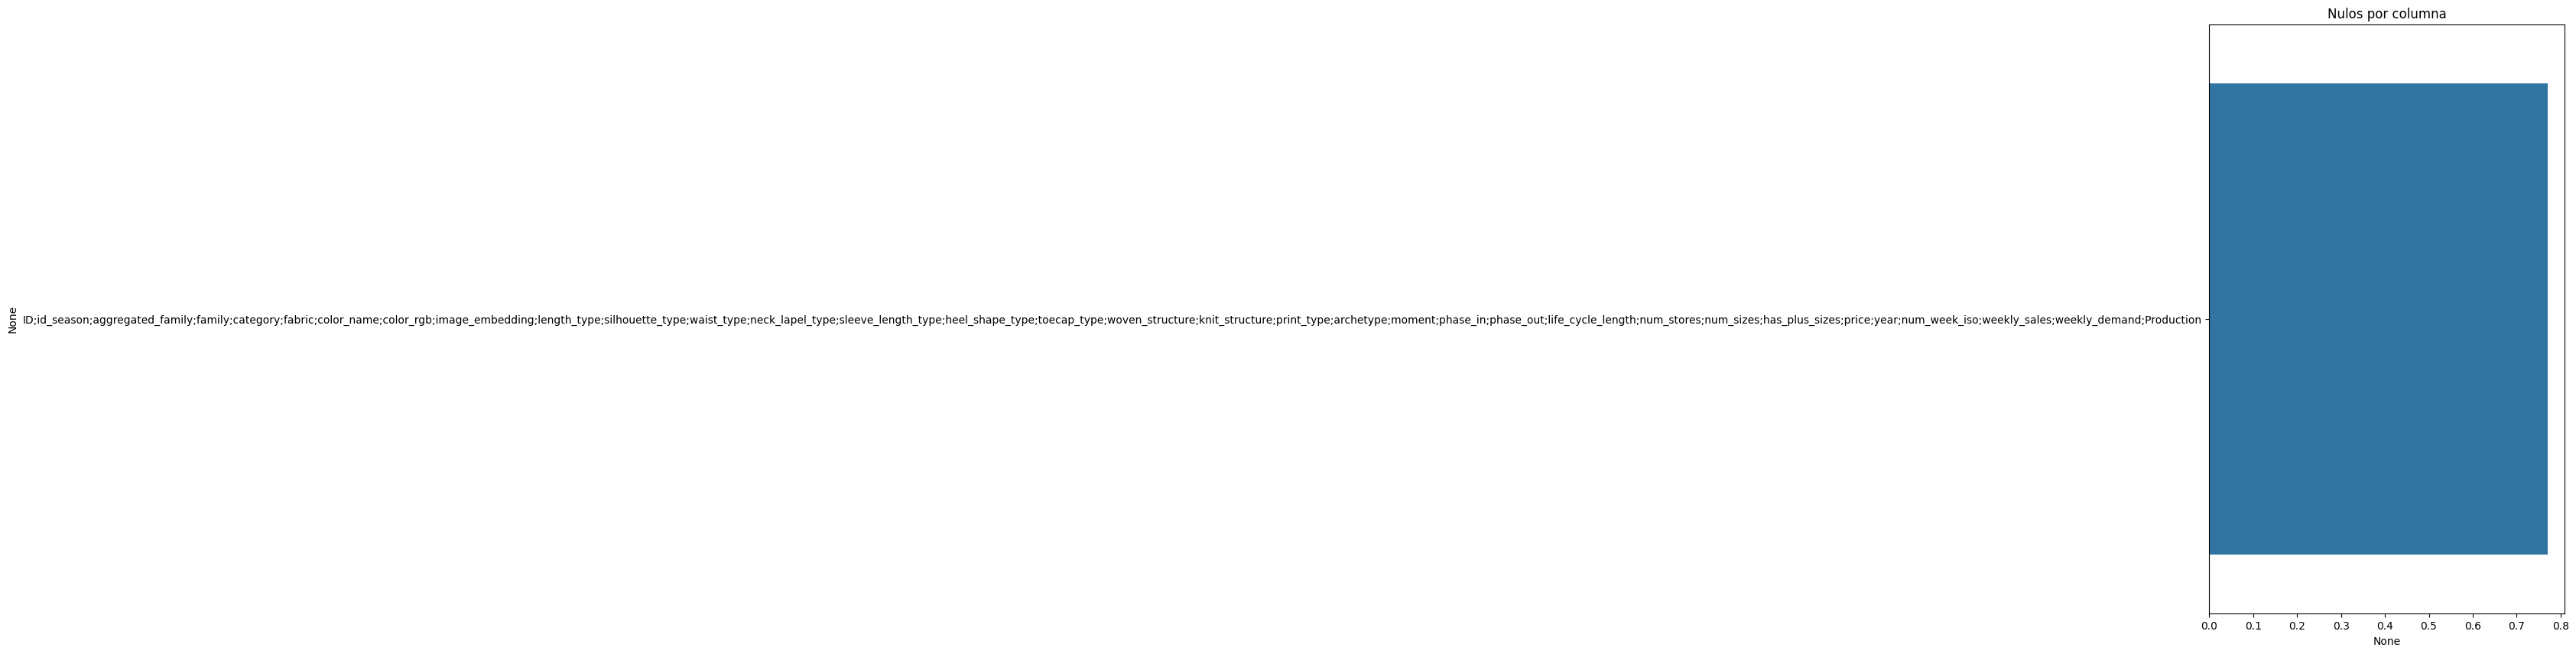


Descriptivo numérico:


ValueError: Cannot describe a DataFrame without columns

In [1]:
# ====================================================================
# 1. IMPORTS
# ====================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import ast

pd.set_option('display.max_columns', None)

# ====================================================================
# 2. CARGA DE DATOS
# ====================================================================
df = pd.read_csv("../mango/train.csv")
print("Tamaño:", df.shape)
display(df.head())

# ====================================================================
# 3. CALIDAD DE DATOS
# ====================================================================

# --- Nulos ---
nulls = df.isna().mean().sort_values(ascending=False)
print("\nPorcentaje de nulos:")
display(nulls)

plt.figure(figsize=(6,10))
sns.barplot(x=nulls, y=nulls.index)
plt.title("Nulos por columna")
plt.show()

# --- Duplicados ---
if "ID" in df.columns:
    print("Duplicados en ID:", df.duplicated("ID").sum())

# ====================================================================
# 4. ANÁLISIS DESCRIPTIVO NUMÉRICO
# ====================================================================
num_cols = df.select_dtypes(include=[np.number]).columns
print("\nDescriptivo numérico:")
display(df[num_cols].describe())

for col in ["weekly_sales", "weekly_demand", "price", "num_stores"]:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribución de {col}")
        plt.show()

# ====================================================================
# 5. ANÁLISIS CATEGÓRICO
# ====================================================================
cat_cols = df.select_dtypes(include=["object"]).columns

for col in cat_cols:
    print(f"\n--- {col} ---")
    print(df[col].value_counts().head(10))

top_features = ["family", "category", "color_name", "fabric"]
for col in top_features:
    if col in df.columns:
        plt.figure(figsize=(10,4))
        df.groupby(col)["weekly_demand"].mean().sort_values(ascending=False).head(15).plot(kind="bar")
        plt.title(f"Demanda promedio por {col}")
        plt.show()

# ====================================================================
# 6. ANÁLISIS TEMPORAL
# ====================================================================
if {"year","num_week_iso"}.issubset(df.columns):
    df_time = df.groupby(["year", "num_week_iso"])["weekly_demand"].sum().reset_index()

    plt.figure(figsize=(12,4))
    sns.lineplot(data=df_time, x="num_week_iso", y="weekly_demand", hue="year")
    plt.title("Demanda semanal por año")
    plt.show()

# ====================================================================
# 7. CICLO DE VIDA (phase_in / phase_out)
# ====================================================================
if {"phase_in","phase_out"}.issubset(df.columns):
    df["phase_in"] = pd.to_datetime(df["phase_in"], errors="coerce")
    df["phase_out"] = pd.to_datetime(df["phase_out"], errors="coerce")

    df["lifecycle_weeks"] = (df["phase_out"] - df["phase_in"]).dt.days / 7

    plt.figure(figsize=(7,4))
    sns.histplot(df["lifecycle_weeks"], kde=True)
    plt.title("Ciclo de vida planeado")
    plt.show()

# ====================================================================
# 8. IMPACTO DE PRECIO Y DISTRIBUCIÓN (num_stores)
# ====================================================================
if {"num_stores","weekly_sales"}.issubset(df.columns):
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df, x="num_stores", y="weekly_sales")
    plt.title("Ventas vs número de tiendas")
    plt.show()

if {"price","weekly_demand"}.issubset(df.columns):
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df, x="price", y="weekly_demand")
    plt.title("Demanda vs precio")
    plt.show()

# ====================================================================
# 9. EMBEDDINGS DE IMAGEN (PCA)
# ====================================================================
if "image_embedding" in df.columns:
    try:
        df["embedding_list"] = df["image_embedding"].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x,str) else np.array(x))
        emb_matrix = np.stack(df["embedding_list"].values)

        scaler = StandardScaler()
        emb_scaled = scaler.fit_transform(emb_matrix)

        pca = PCA(n_components=2)
        emb_pca = pca.fit_transform(emb_scaled)

        df["emb_pca_1"], df["emb_pca_2"] = emb_pca[:,0], emb_pca[:,1]

        plt.figure(figsize=(7,6))
        sns.scatterplot(x="emb_pca_1", y="emb_pca_2", hue="category", data=df, s=10)
        plt.title("PCA de embeddings de imagen")
        plt.show()
    except:
        print("⚠️ No se pudo convertir image_embedding a listas numéricas.")

# ====================================================================
# 10. CORRELACIONES
# ====================================================================
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Matriz de correlaciones")
plt.show()

# ====================================================================
# 11. PERFILES DE PRODUCTO (Understock / Overstock)
# ====================================================================
if {"Production","weekly_demand"}.issubset(df.columns):
    df["understock"] = df["Production"] < df["weekly_demand"]
    df["overstock"] = df["Production"] > df["weekly_demand"]

    print("\n% Understock:", df["understock"].mean())
    print("% Overstock:", df["overstock"].mean())

    print("\nTop categorías por desempeño:")
    if "category" in df.columns:
        display(
            df.groupby("category")[["weekly_sales","weekly_demand","Production"]]
              .mean()
              .sort_values("weekly_demand", ascending=False)
              .head(10)
        )

# ====================================================================
# FIN DEL EA
# ====================================================================
print("\nEA COMPLETO 🚀")
